In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# scipy 1.6
from tslearn.clustering import TimeSeriesKMeans
from tslearn.barycenters import dtw_barycenter_averaging

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE, MDS

from tqdm.autonotebook import tqdm

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

SEED=23

In [2]:
df = pd.read_csv('Article_top_Data.csv')
df.head()

,Unnamed: 0,Date,StoreNumber,CashRegisterNumber,ReceiptNumber,ReceiptRowNumber,Time,ArticleNumber,ArticleName,Quantity,Timestamp,Month,Day,Hour,Group
0,4,2022-01-03,1001,1,296,5,09:21:14,419727,"GL H-Milch 3,5% 1L VLOG",1.0,2022-01-03 09:21:14,1,0,9,Milch
1,6,2022-01-03,1001,1,296,7,09:21:14,999999998025,Pfandartikel (Tandem) - EW,1.0,2022-01-03 09:21:14,1,0,9,Pfandartikel
2,7,2022-01-03,1001,1,296,8,09:21:14,435066,Schlaufentragetasche ST,1.0,2022-01-03 09:21:14,1,0,9,Schlaufentragetasche ST
3,19,2022-01-03,1001,1,300,1,09:25:34,421791,BO-Laugenbreze 1ST,1.0,2022-01-03 09:25:34,1,0,9,BO-Laugenbreze 1ST
4,20,2022-01-03,1001,1,300,2,09:25:34,421791,BO-Laugenbreze 1ST,1.0,2022-01-03 09:25:34,1,0,9,BO-Laugenbreze 1ST


# TimeSeries

In [3]:
stores = []
stores_del = []
for store in df.StoreNumber.unique():
    current_ = df.query(f"StoreNumber == {store}")
    if(current_.Month.unique().shape[0] == 12):
        stores.append(store)
    else:
        stores_del.append(store)
df_ts = df[df.StoreNumber.isin(stores)]

In [4]:
print(df_ts.StoreNumber.unique().shape[0])
print(stores_del)

14
[]


In [5]:
ts_sales = df_ts.groupby(['Date', 'StoreNumber'], as_index=False).aggregate({'Quantity': 'sum'})
ts_sales.head()

,Date,StoreNumber,Quantity
0,2022-01-03,1001,1350.730
1,2022-01-03,1007,530.000
2,2022-01-03,1028,1471.402
3,2022-01-03,1033,1410.580
4,2022-01-03,1053,1283.264


<AxesSubplot:xlabel='Date', ylabel='Quantity'>

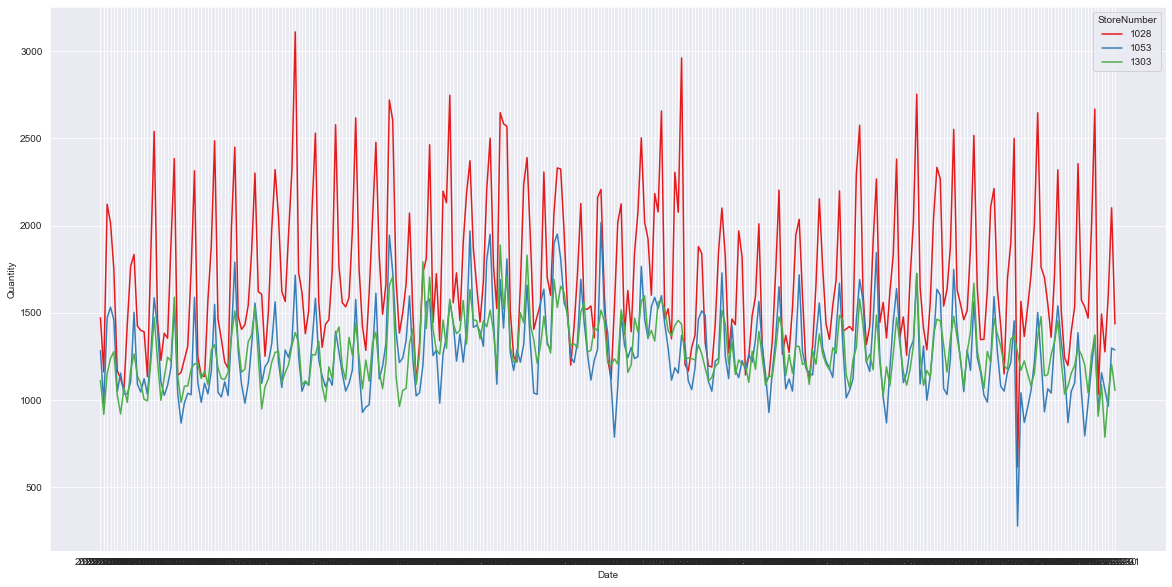

In [6]:
rand_stores = np.random.choice(ts_sales.StoreNumber.unique(), 3)
selected_stores = ts_sales[ts_sales.StoreNumber.isin(rand_stores)]

plt.figure(figsize=(20,10))
plt.grid(True)
sns.lineplot(data=selected_stores, x='Date', y='Quantity', hue='StoreNumber', ci=False, legend=True, palette='Set1')

In [7]:
# Find noisy series 
store_to_drop = []
for store in ts_sales['StoreNumber'].unique():
    current_store = ts_sales.query(f'StoreNumber == {store}')
    if current_store.query('Quantity == 0').shape[0]/current_store.shape[0] > 0.3:
        store_to_drop.append(store)
        
print('Noisy Stores: ', store_to_drop)

# Drop noisy stores
store_sales = ts_sales[~ts_sales['StoreNumber'].isin(store_to_drop)]

Noisy Stores:  []


In [8]:
# Time Series Smoothing
res_df = pd.DataFrame()
for store in ts_sales['StoreNumber'].unique():
    current_store = ts_sales.query(f'StoreNumber == {store}')
    current_store['smooth_6'] = current_store['Quantity'].rolling(6).mean()
    res_df = res_df.append(current_store[['Date', 'StoreNumber', 'smooth_6']])
    
ts_sales = res_df
ts_sales = ts_sales.dropna()

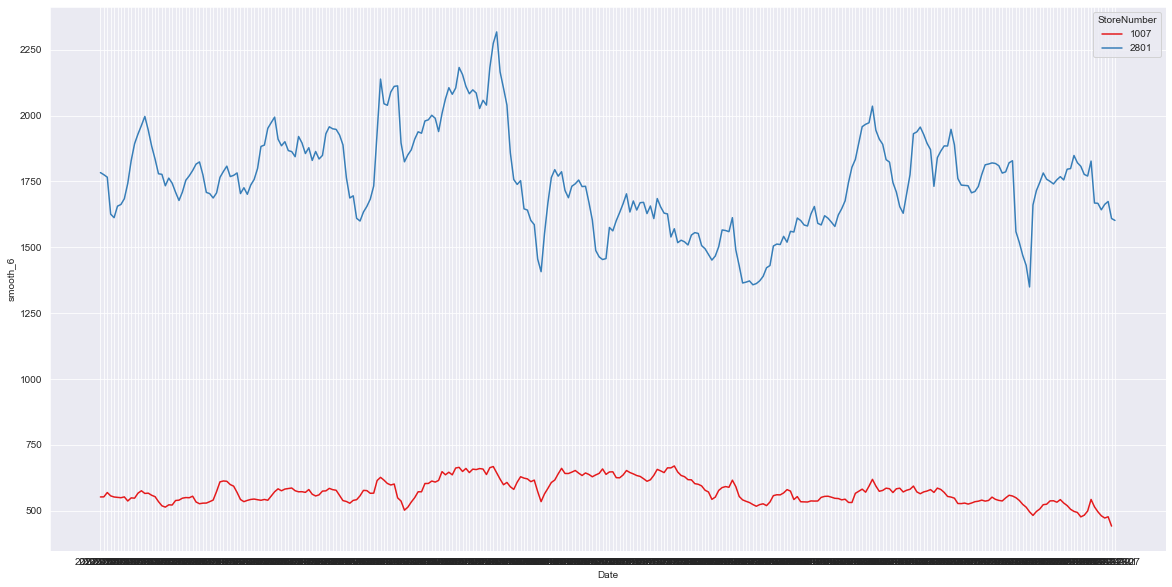

In [9]:
# Let's have a look at 3 different stores 
rand_stores = np.random.choice(ts_sales['StoreNumber'].unique(), 3)
selected_stores = ts_sales[ts_sales['StoreNumber'].isin(rand_stores)][['Date', 'StoreNumber', 'smooth_6']]

plt.figure(figsize=(20,10))
plt.grid(True)
sns.lineplot(data=selected_stores, x='Date', y='smooth_6', hue='StoreNumber', ci=False, legend=True, palette='Set1');

In [10]:
ts_sales.head()

,Date,StoreNumber,smooth_6
70,2022-01-10,1001,1412.515333
84,2022-01-11,1001,1368.071333
98,2022-01-12,1001,1381.129000
112,2022-01-13,1001,1263.626333
126,2022-01-14,1001,1216.290333


In [11]:
# Feature matrix with shape (n_series x time_observations)
ts_series = ts_sales.pivot(index='StoreNumber', columns='Date', values='smooth_6')
ts_series = ts_series.dropna(axis='columns')
ts_series.head()

Date,2022-01-10,2022-01-11,2022-01-12,2022-01-13,2022-01-14,2022-01-15,2022-01-17,2022-01-18,2022-01-19,2022-01-20,...,2022-12-20,2022-12-21,2022-12-22,2022-12-23,2022-12-24,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
StoreNumber,,,,,,,,,,,,,,,,,,,,,
1001,1412.515333,1368.071333,1381.129000,1263.626333,1216.290333,1262.801333,1252.371333,1244.575000,1273.255333,1303.305000,...,1490.974667,1511.664333,1565.177333,1627.476667,1530.421333,1539.475667,1510.171000,1568.253667,1638.374667,1588.581000
1007,552.612333,552.877667,569.384333,556.693333,552.398333,551.136667,549.607667,552.764000,537.165333,549.041667,...,476.971000,483.289000,499.133667,543.112000,515.115000,496.256667,481.166000,472.611000,477.352667,441.976667
1028,1614.902000,1556.901333,1539.255333,1424.716333,1383.296000,1397.360000,1439.945667,1485.963333,1541.876333,1491.692333,...,1598.131000,1643.528333,1740.879333,1929.958333,1709.687667,1696.499333,1653.456000,1674.625000,1694.810333,1489.595000
1033,1547.399333,1531.607000,1533.177000,1419.396333,1375.435000,1357.623000,1338.918667,1310.836333,1304.466000,1294.276000,...,1239.104667,1240.106000,1303.534667,1374.679333,1337.275333,1354.702000,1392.070333,1407.844000,1457.425000,1397.237333
1053,1295.988333,1274.592333,1283.651333,1211.035000,1139.603333,1146.647667,1153.826667,1135.729333,1150.359000,1149.837000,...,1040.886000,1059.650667,1081.933000,1127.687000,1052.098667,1070.368667,1114.539333,1111.354000,1130.222667,1116.120333


In [12]:
# First transposition - to have series in columns (allows scaling each series independently)
# Second Transposition - come back to initial feature matrix shape (n_series x time_observations)
scaler = StandardScaler()
scaled_ts = scaler.fit_transform(ts_series.T).T 
scaled_ts[0:5]

array([[-0.60748964, -0.93960226, -0.84202742, ...,  0.556282  ,
         1.08026879,  0.7081802 ],
       [-0.46254199, -0.45672313, -0.09472569, ..., -2.21700145,
        -2.11301491, -2.88882396],
       [-0.62972338, -0.98179832, -1.08891285, ..., -0.26719356,
        -0.1446648 , -1.3903604 ],
       [ 1.17546891,  1.05634821,  1.06819063, ...,  0.12281075,
         0.49679749,  0.04280525],
       [ 0.14244107, -0.03406859,  0.04066505, ..., -1.38072885,
        -1.22506882, -1.34140823]])

In [13]:
# Run KMeans and plot the results 
def get_kmeans_results(data, max_clusters=10, metric='euclidean', seed=23):
    # Main metrics
    distortions = []
    silhouette = []
    clusters_range = range(1, max_clusters+1)
    
    for K in tqdm(clusters_range):
        kmeans_model = TimeSeriesKMeans(n_clusters=K, metric=metric, n_jobs=-1, max_iter=10, random_state=seed)
        kmeans_model.fit(data)
        distortions.append(kmeans_model.inertia_)
        if K > 1:
            silhouette.append(silhouette_score(data, kmeans_model.labels_))
        
    # Visualization
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range, distortions, 'bx-')
    plt.xlabel('k', fontsize=18)
    plt.ylabel('Distortion',fontsize=18)
    plt.title('Elbow Method',fontsize=20)
    plt.xticks(fontsize=15)  
    plt.yticks(fontsize=15)
    
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range[1:], silhouette, 'bx-')
    plt.xlabel('k', fontsize=18)
    plt.ylabel('Silhouette score', fontsize=18)
    plt.title('Silhouette',fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

In [14]:
# Visualization for obtained clusters   
def plot_clusters(data, cluster_model, dim_red_algo):
    
    cluster_labels = cluster_model.fit_predict(data)
    centroids = cluster_model.cluster_centers_
    u_labels = np.unique(cluster_labels)
    
    # Centroids Visualization
    plt.figure(figsize=(16, 10))
    plt.scatter(centroids[:, 0] , centroids[:, 1] , s=150, color='r', marker="x")
    
    # Downsize the data into 2D
    if data.shape[1] > 2:
        print("data need to be downsized")
        data_2d = dim_red_algo.fit_transform(data)
        for u_label in u_labels:
            cluster_points = data_2d[(cluster_labels == u_label)]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=u_label)
    else:
        for u_label in u_labels:
            cluster_points = data[(cluster_labels == u_label)]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=u_label)

    plt.title('Clustered Data')
    plt.xlabel("Feature space for the 1st feature")
    plt.ylabel("Feature space for the 2nd feature")
    plt.grid(True)
    plt.legend(title='Cluster Labels');

100%|██████████| 10/10 [00:00<00:00, 75.21it/s]


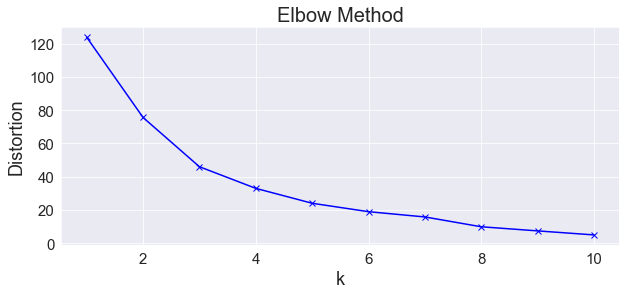

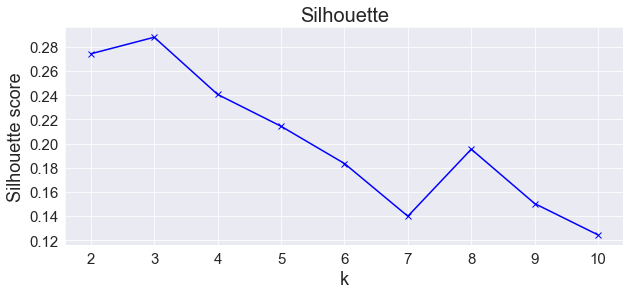

In [15]:
# Downsize the features into 2D
mds = MDS(n_components=2, n_init=3, max_iter=100, random_state=SEED)
data_mds = mds.fit_transform(scaled_ts) 

get_kmeans_results(data=data_mds, max_clusters=10, metric='euclidean', seed=SEED)

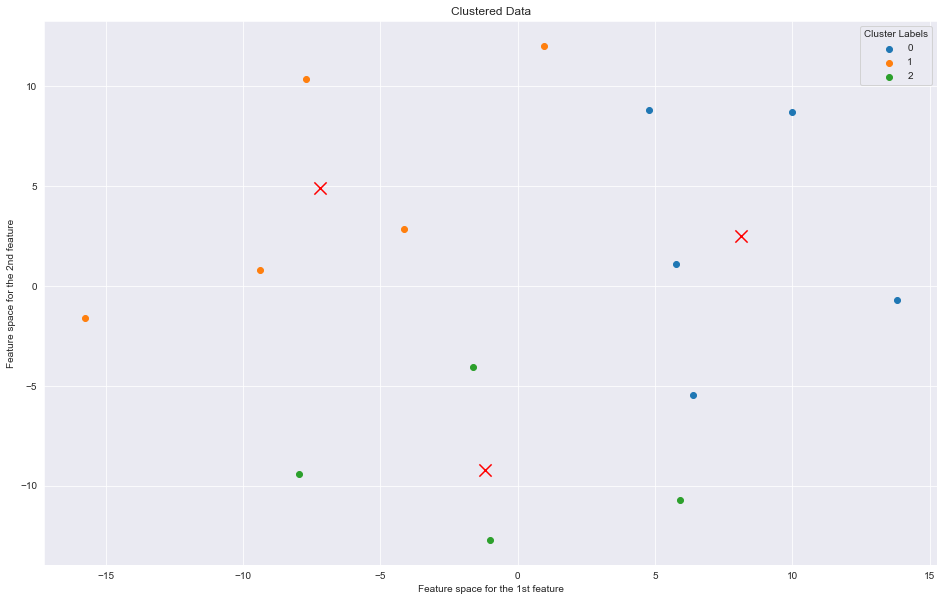

In [16]:
# let's look at the cluster shape
model = TimeSeriesKMeans(n_clusters=3, metric='euclidean', n_jobs=-1, max_iter=10, random_state=SEED)

plot_clusters(data=data_mds,
              cluster_model=model,
              dim_red_algo=TSNE(n_components=2, init='pca', random_state=SEED))

In [17]:
# Train TimeSeriesKMeans with MDS
kmeans_model = TimeSeriesKMeans(n_clusters=3, metric='euclidean', n_jobs=-1, max_iter=10, random_state=SEED)
cluster_labels = kmeans_model.fit_predict(data_mds)

# output every clusters
clusters = {}
for i in range(3):
    ind = np.where(cluster_labels==i)
    clusters[i]=ts_series.index[ind].to_list()
print(clusters)

ts_clustered = [scaled_ts[(cluster_labels == label), :] for label in np.unique(cluster_labels)]
print(ts_clustered[0])

{0: [1007, 1033, 1053, 1223, 1311], 1: [1001, 1028, 1098, 1303, 1487], 2: [1417, 1436, 1504, 2801]}
[[-0.46254199 -0.45672313 -0.09472569 ... -2.21700145 -2.11301491
  -2.88882396]
 [ 1.17546891  1.05634821  1.06819063 ...  0.12281075  0.49679749
   0.04280525]
 [ 0.14244107 -0.03406859  0.04066505 ... -1.38072885 -1.22506882
  -1.34140823]
 [ 0.1698945  -0.12524339  0.09580018 ... -0.9992279  -0.84557913
  -1.60122315]
 [ 0.08963967 -0.0393883  -0.09772403 ... -0.24311517 -0.13788025
  -0.71134802]]


In [18]:
len(ts_clustered)

3

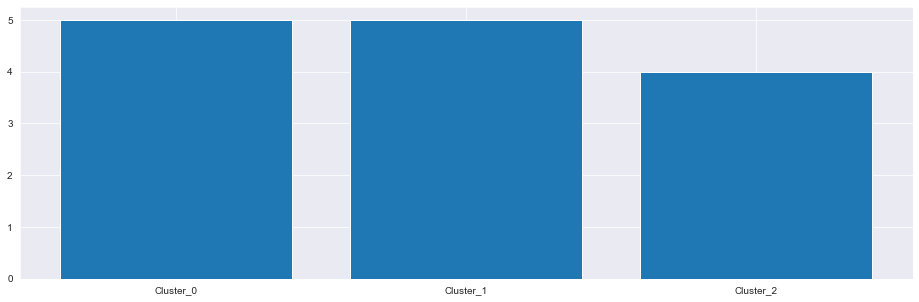

In [19]:
# Objects distribution in the obtained clusters 
labels = [f'Cluster_{i}' for i in range(len(ts_clustered))]
samples_in_cluster = [val.shape[0] for val in ts_clustered]

plt.figure(figsize=(16,5))
plt.bar(labels, samples_in_cluster);

In [20]:
def plot_cluster_ts(current_cluster):

    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),4,
        figsize=(45, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)
    for indx, series in enumerate(current_cluster):
        ax[indx].plot(series)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show();

==========Cluster number: 0==========
[1007, 1033, 1053, 1223, 1311]


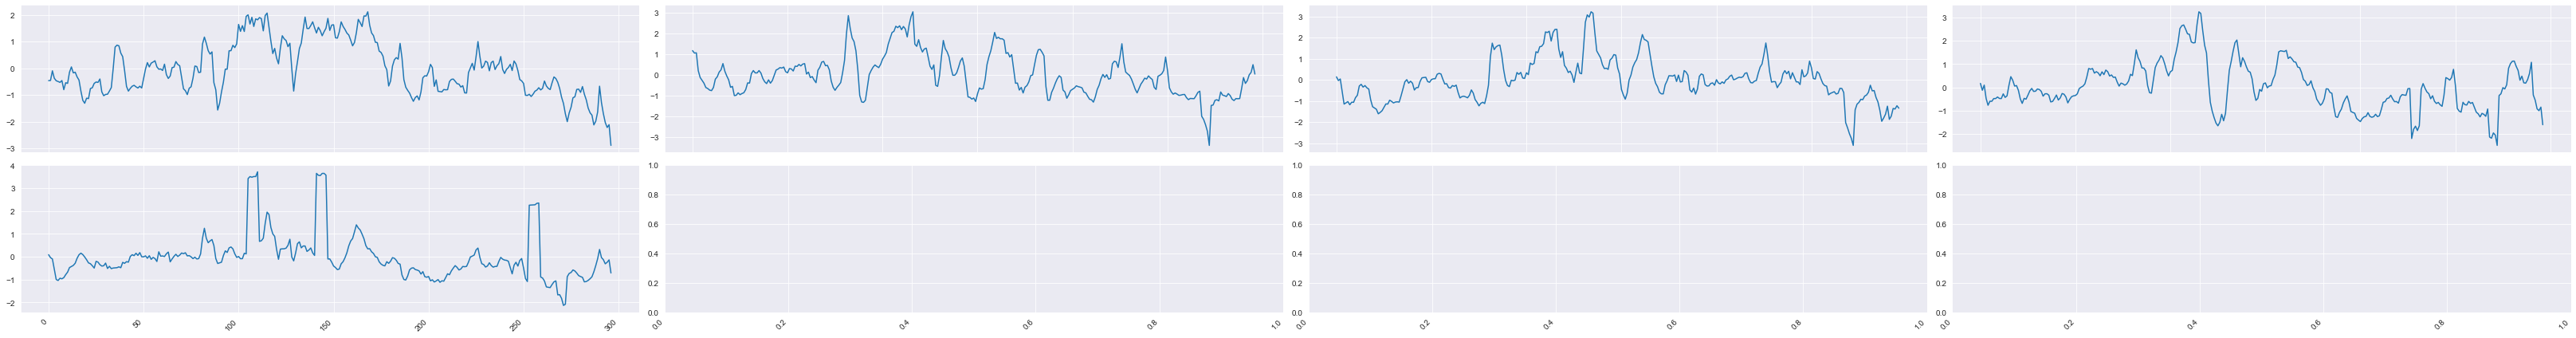

==========Cluster number: 1==========
[1001, 1028, 1098, 1303, 1487]


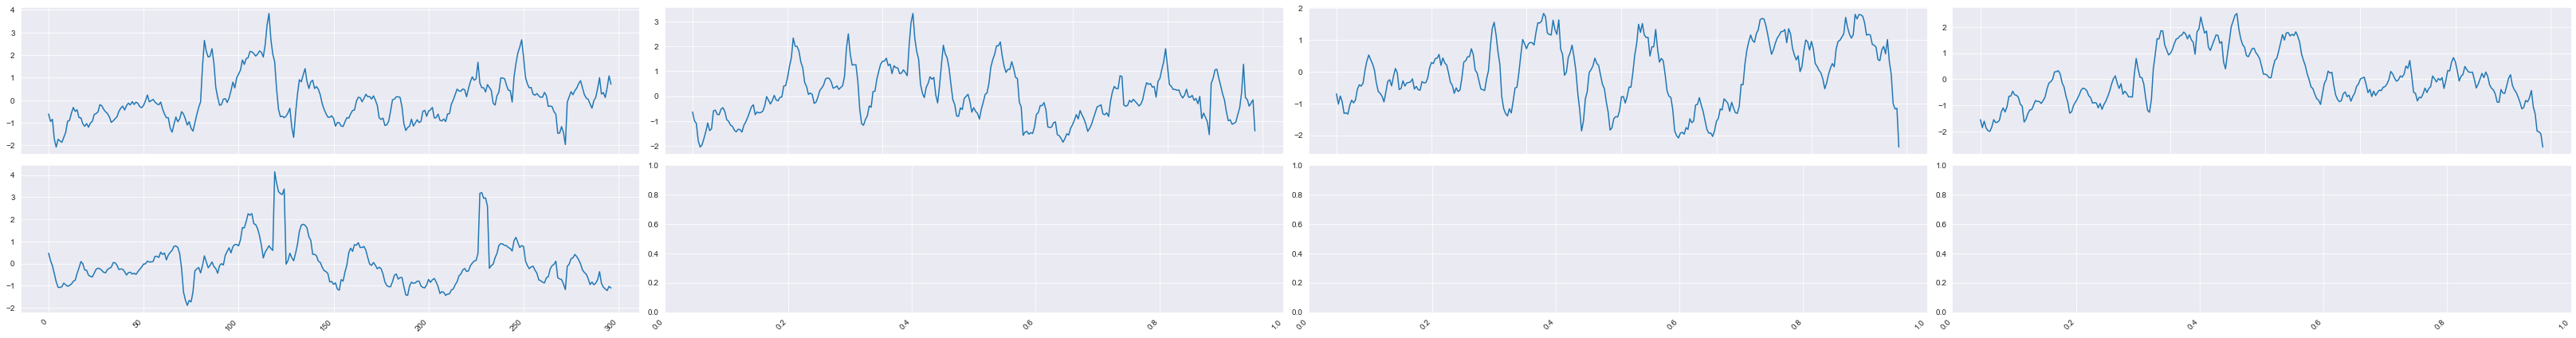

==========Cluster number: 2==========
[1417, 1436, 1504, 2801]


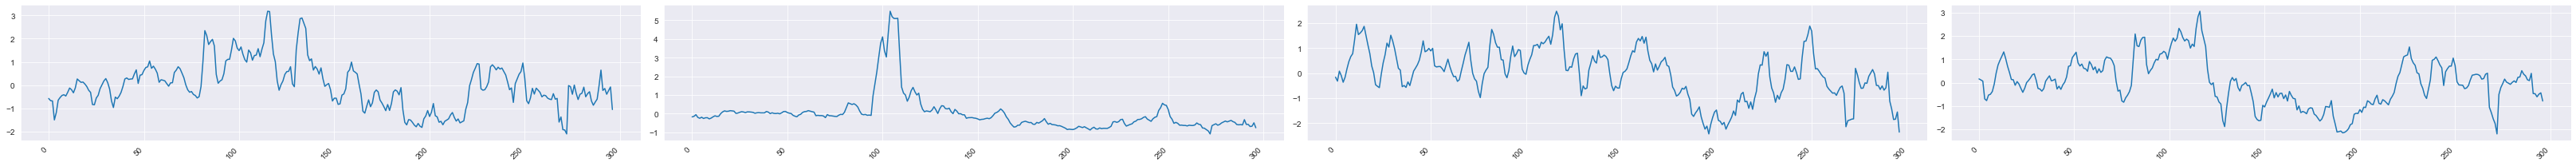

In [21]:
for cluster in range(len(ts_clustered)):
    print(f"==========Cluster number: {cluster}==========")
    print(clusters[cluster])
    plot_cluster_ts(ts_clustered[cluster])

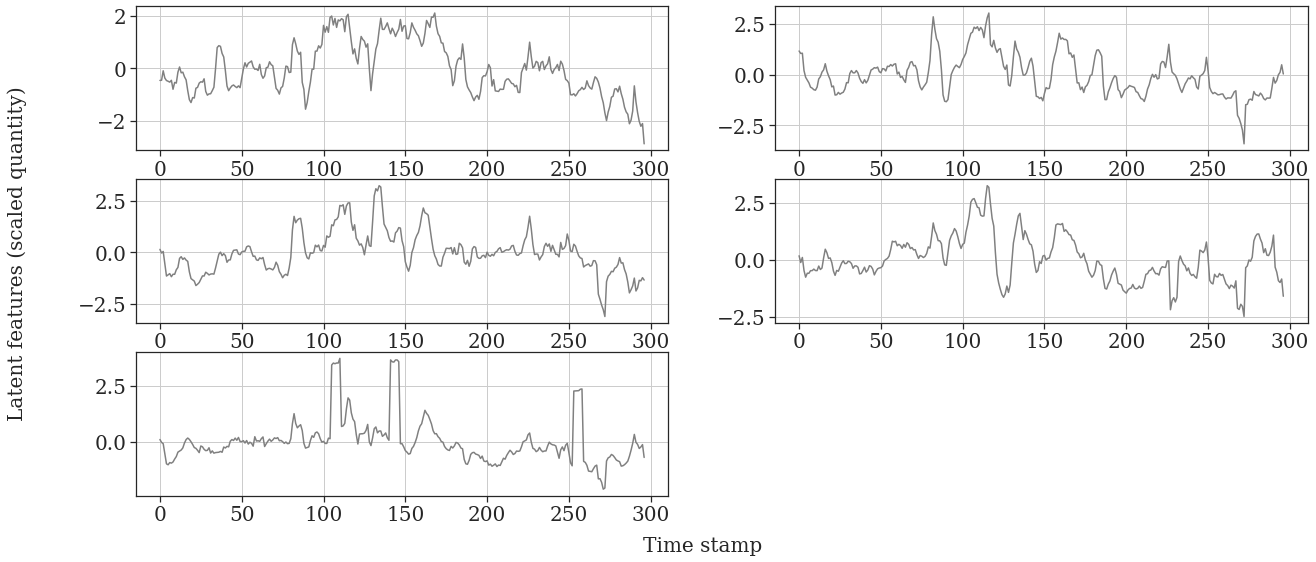

In [32]:
# fig, ax = plt.subplots(3, 2, figsize=(21, 9))
# for i, ax_row in enumerate(ax):
#     for j, ax_col in enumerate(ax_row):
#         if i * 2 + j < 5:
#             ax_col.plot(ts_clustered[0][i * 2 + j], color='gray')
#             ax_col.tick_params(axis='x', labelsize=20) 
#             ax_col.tick_params(axis='y', labelsize=20)


        
#         else:
#             ax_col.remove()

# fig.text(0.5, 0.04, 'Time stamp', ha='center', fontsize=20)
# fig.text(0.04, 0.5, 'Latent features (scaled quantity)', va='center', rotation='vertical',fontsize=20)

# plt.savefig("cluster_result.pdf", format="pdf", bbox_inches="tight")

# plt.show() 

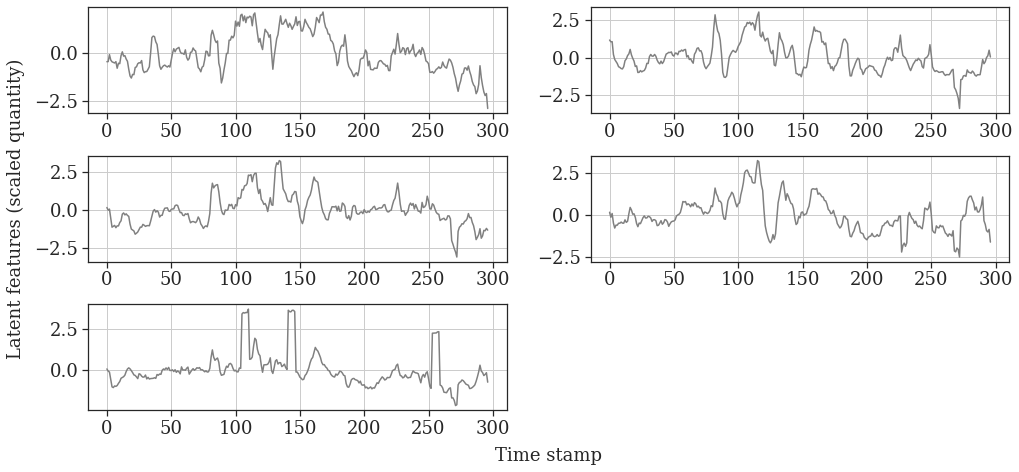

In [33]:
font_title = {"family" : "serif",
              #"color" : "darkblue",
              "weight" : "bold",
              "size" : 12}

font_text = {"family" : "serif",
             #"color" : "black",
             "weight" : "normal",
             "size" : 20}

font_annot = {"family" : "serif",
              #"color" : "black",
              "weight" : "normal",
              "size" : 8}

font_size = 18

sns.set(font = "serif", 
        font_scale = 1.0, 
        style = "ticks")


# fig, ax = plt.subplots(3, 2, figsize=(21, 9))
# for i, ax_row in enumerate(ax):
#     for j, ax_col in enumerate(ax_row):
#         if i * 2 + j < 5:
#             ax_col.plot(ts_clustered[2][i * 2 + j])
#             ax_col.tick_params(axis='x', labelsize=20) 
#             ax_col.tick_params(axis='y', labelsize=20)
#         else:
#             ax_col.remove()

# fig.text(0.5, 0.04, 'Time stamp', ha='center', fontsize=20)
# fig.text(0.04, 0.5, 'Latent features (scaled quantity)', va='center', rotation='vertical',fontsize=20)
plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(3, 2, figsize=(16, 7))
for i, ax_row in enumerate(ax):
    for j, ax_col in enumerate(ax_row):
        if i * 2 + j < 5:
            ax_col.plot(ts_clustered[0][i * 2 + j], color = "gray")
            ax_col.tick_params(axis='x', labelsize = font_size) 
            ax_col.tick_params(axis='y', labelsize = font_size)      
        else:
            ax_col.remove()

fig.text(0.5, 0.00, 'Time stamp', ha='center', fontsize = font_size)
fig.text(0.03, 0.5, 'Latent features (scaled quantity)', va='center', rotation='vertical',fontsize = font_size)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

plt.savefig("cluster_result.pdf", format="pdf", bbox_inches="tight")

plt.show() 

In [23]:
# Closest Series to Cluster Centroid
closest_clusters_indxs = [np.argmin([np.linalg.norm(cluster_center - point, ord=2) for point in data_mds]) \
                                                                        for cluster_center in kmeans_model.cluster_centers_]

closest_ts = scaled_ts[closest_clusters_indxs, :]

In [24]:
# DBA
dba_ts = [dtw_barycenter_averaging(cluster_serieses, max_iter=10, verbose=True) for cluster_serieses in ts_clustered]

Attempt 1
[DBA] epoch 1, cost: 46.339
[DBA] epoch 2, cost: 31.999
[DBA] epoch 3, cost: 27.923
[DBA] epoch 4, cost: 25.915
[DBA] epoch 5, cost: 24.777
[DBA] epoch 6, cost: 24.349
[DBA] epoch 7, cost: 24.301
[DBA] epoch 8, cost: 24.290
[DBA] epoch 9, cost: 24.289
[DBA] epoch 10, cost: 24.289
Attempt 1
[DBA] epoch 1, cost: 41.047
[DBA] epoch 2, cost: 30.257
[DBA] epoch 3, cost: 28.384
[DBA] epoch 4, cost: 26.056
[DBA] epoch 5, cost: 25.760
[DBA] epoch 6, cost: 25.629
[DBA] epoch 7, cost: 25.610
[DBA] epoch 8, cost: 25.609
[DBA] epoch 9, cost: 25.609
Attempt 1
[DBA] epoch 1, cost: 41.347
[DBA] epoch 2, cost: 24.280
[DBA] epoch 3, cost: 22.718
[DBA] epoch 4, cost: 22.348
[DBA] epoch 5, cost: 22.262
[DBA] epoch 6, cost: 22.225
[DBA] epoch 7, cost: 22.225


In [25]:
# CLUSTER_N = 2

# plt.figure(figsize=(25, 5))
# plt.plot(ts_clustered[CLUSTER_N].T,  alpha = 0.4) # all series in the cluster_1
# plt.plot(closest_ts[CLUSTER_N], c = 'r', label='Cluster Time Series')
# plt.title('Cluster Series - Closest to Cluster Centroid. Cluster 1')
# plt.legend();

# plt.figure(figsize=(25, 5))
# plt.plot(ts_clustered[CLUSTER_N].T,  alpha = 0.4) 
# plt.plot(np.mean(ts_clustered[CLUSTER_N], axis=0), c = 'r', label='Cluster Time Series')
# plt.title('Cluster Series - Cluster Mean. Cluster 1')
# plt.legend();

# plt.figure(figsize=(25, 5))
# plt.plot(ts_clustered[CLUSTER_N].T,  alpha = 0.4) 
# plt.plot(dba_ts[CLUSTER_N], c = 'r', label='Cluster Time Series')
# plt.title('Cluster Series - DBA. Cluster 1')
# plt.legend();

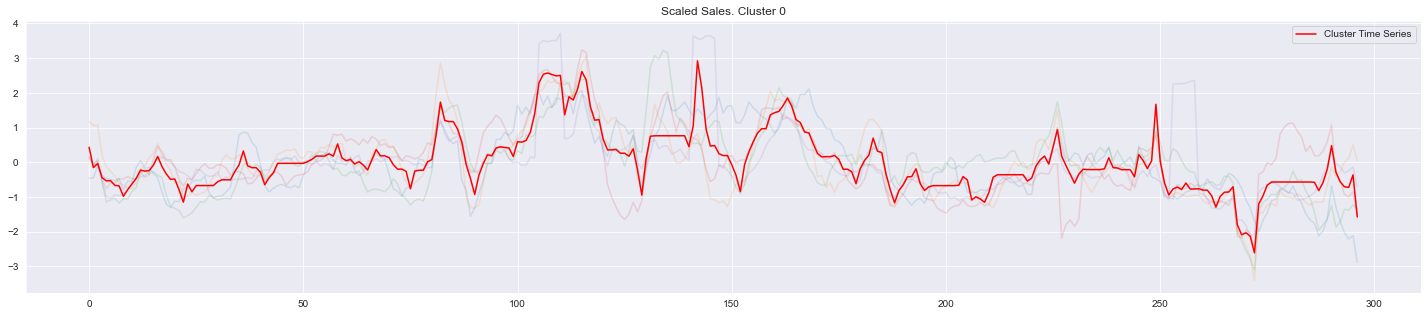

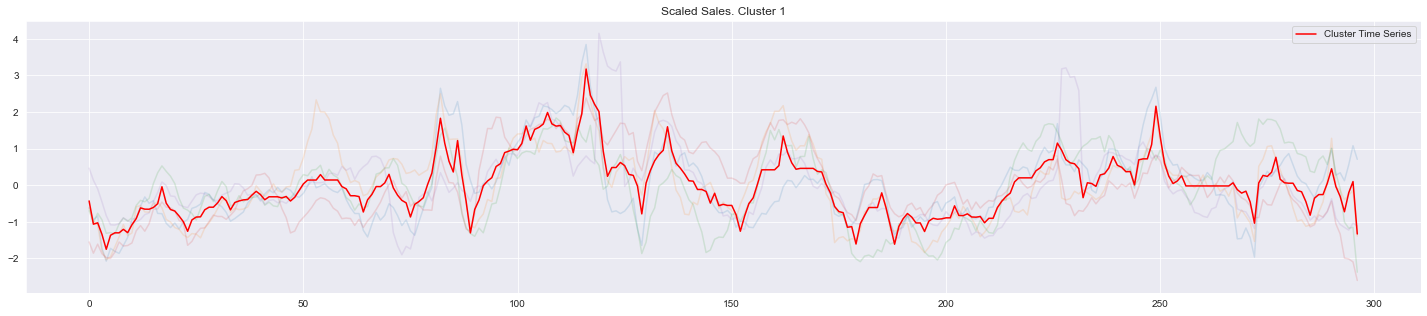

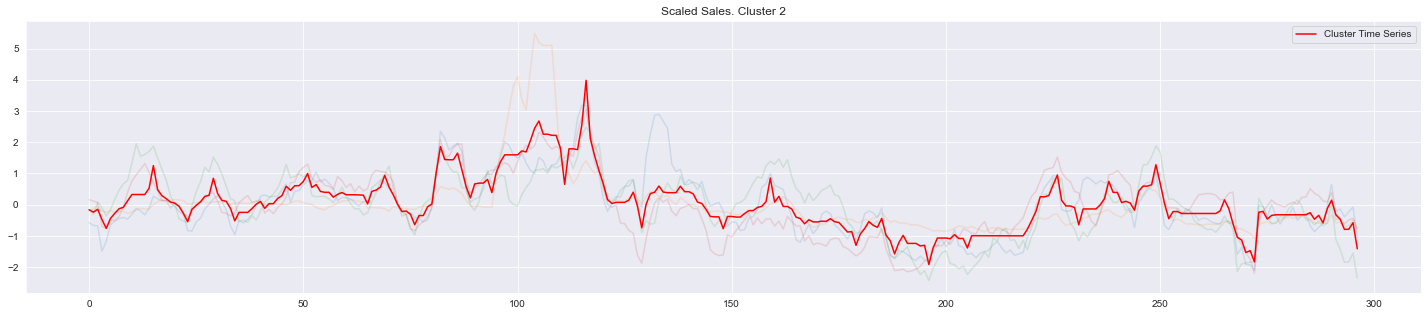

In [26]:
# extract all clusters series by DBA
for indx, series in enumerate(dba_ts):
    plt.figure(figsize=(25, 5))
    plt.plot(ts_clustered[indx].T,  alpha = 0.15)
    plt.plot(series, c = 'r', label='Cluster Time Series')
    plt.title(f'Scaled Sales. Cluster {indx}')
    plt.legend();